In [2]:
# some imports 
import os 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Bidirectional, GlobalMaxPooling1D, Lambda, Concatenate, Dense
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# mount this notebook to your drive
from google.colab import drive
drive.mount('/content/gdrive')

import os 
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/kaggle_dataset'


path = '/content/gdrive/MyDrive/kaggle_dataset/mnist'
if not os.path.exists(path):
    os.makedirs(path)

%cd /content/gdrive/MyDrive/kaggle_dataset/mnist

Mounted at /content/gdrive
/content/gdrive/MyDrive/kaggle_dataset/mnist


In [13]:
# load mnist dataset to drive
# if the data does not exist or want to replace it

#!kaggle competitions download -c digit-recognizer
#!unzip digit-recognizer.zip

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  digit-recognizer.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [21]:
def mnist_imgs():
  print('Reading and Transforming data...')
  df = pd.read_csv('train.csv')  
  data = df.values # convert to numpy matrix == df.to_numpy()
  np.random.shuffle(data)
  X = data[:, 1:].reshape(-1, 28, 28) / 255.0 # first col is the label
  Y = data[:, 0]
  return X, Y

In [22]:
X, Y = mnist_imgs()
print("shape of X:", X.shape)
print("shape of Y:", Y.shape)

Reading and Transforming data...
shape of X: (42000, 28, 28)
shape of Y: (42000,)


In [28]:
D = 28   # input Dimensionality
M = 15   # hidden layer size

In [29]:
# input is an image of size 28*28
input_ = Input(   shape=(D, D)  )

# up-down
rnn1 = Bidirectional(   LSTM(M, return_sequences=True)  ) # get back all hidden states
x1 = rnn1(input_)               # output is N * D * 2M
x1 = GlobalMaxPooling1D()(x1)   # output is N * 2M

In [30]:
# left-right
rnn2 = Bidirectional(   LSTM(M, return_sequences=True)  )

# now, we need to transpose the image, so height becomes width and width becomes height
# custom layer
permutor = Lambda(lambda t: K.permute_dimensions(t, pattern=(0, 2, 1)))

x2 = permutor(input_)
x2 = rnn2(x2)                   # output is N * D * 2M
x2 = GlobalMaxPooling1D()(x2)   # output is N * 2M

In [31]:
# put them together
conactenate = Concatenate(axis=1)
x = conactenate([x1, x2])         # output is N * 4M

# finel dense layer
output = Dense(10, activation='softmax')(x)
model = Model(inputs=input_, outputs=output)

In [32]:
# testing
# o = model.predict(X)
# print("o.shape:", o.shape)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print('Training Model...')
h = model.fit(X, Y, batch_size=32, epochs=10, validation_split=0.3)

Training Model...
Epoch 1/10
919/919 [==============================] - 24s 15ms/step - loss: 0.7843 - accuracy: 0.8071 - val_loss: 0.3067 - val_accuracy: 0.9171
Epoch 2/10
919/919 [==============================] - 15s 17ms/step - loss: 0.2551 - accuracy: 0.9305 - val_loss: 0.2107 - val_accuracy: 0.9373
Epoch 3/10
919/919 [==============================] - 15s 16ms/step - loss: 0.1862 - accuracy: 0.9464 - val_loss: 0.1707 - val_accuracy: 0.9471
Epoch 4/10
919/919 [==============================] - 13s 14ms/step - loss: 0.1503 - accuracy: 0.9576 - val_loss: 0.1465 - val_accuracy: 0.9567
Epoch 5/10
919/919 [==============================] - 13s 14ms/step - loss: 0.1296 - accuracy: 0.9620 - val_loss: 0.1319 - val_accuracy: 0.9609
Epoch 6/10
919/919 [==============================] - 13s 14ms/step - loss: 0.1113 - accuracy: 0.9666 - val_loss: 0.1140 - val_accuracy: 0.9660
Epoch 7/10
919/919 [==============================] - 13s 14ms/step - loss: 0.1026 - accuracy: 0.9692 - val_loss: 0.11

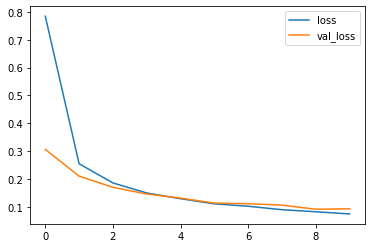

In [33]:
plt.plot(h.history['loss'] ,label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

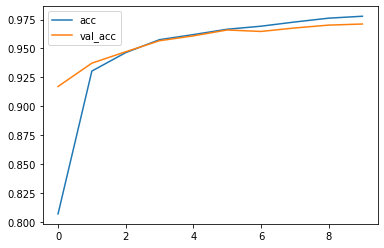

In [34]:
plt.plot(h.history['accuracy'] ,label='acc')
plt.plot(h.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()